In [41]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from COG import COGTranslator, COGFunctions
import re
import seaborn as sns
cogt = COGTranslator()
cogf = COGFunctions()

Loaded 4631 COG names into memory.


## Plot versions
### Grouping: By genome or By genus
#### Columns: mask COG categories

- By genome, no masking
- By genome, keeping only metabolism
- By genome, excluding information storage and processing
- By genus, no masking
- By genus, keeping only metabolism
- By genus, excluding information storage and processing.

### Masks and dictionaries

In [42]:
def not_information_process(cog_code):
    if cogt.letter_from_code(cog_code)[0][1][0] != 'Information storage and processing':
        return True
    else:
        return False


def is_metabolism(cog_code):
    if cogt.letter_from_code(cog_code)[0][1][0] != 'Metabolism':
        return True
    else:
        return False
    
    
color_dict = {
    "Freshwater":"#5AA36D",
    "Marine":"#597BB0",
    "Thermophilic":"#653F81"
}


ecotypes = {
    'Enugrolinea': 'Freshwater',
    'Inmanicoccus': 'Marine',
    'Lacustricoccus': 'Marine',
    'Leptococcus':'Thermophilic',
    'Magnicoccus':'Marine',
    'Parasynechococcus':'Marine',
    'Pseudosynechococcus':'Marine',
    'Regnicoccus':'Marine',
    'Synechococcus':'Freshwater',
    'Synechospongium':'Marine',
    'Thermosynechococcus':'Thermophilic'
}

### Plotting function

In [88]:
file = "../data/tables/cog/CyCOG_codes_as_cols_absolute_95_completeness.csv"

def plotCOG(path=file, mask=False, groupby_genus=False, save=False, **kwargs):
    data = pd.read_csv(path)
    data.set_index("name", inplace=True)
    if mask:
        data = data[[i for i in data.columns if mask(i)]]

    # Add COG names
    columns = (cogt.name_from_code(i) for i in data.columns)
    data.columns = columns


    # Collapse columns with same name
    suffix = re.compile("\.[0-9]{1,2}$")
    collapsed_columns = []
    for s in data.columns:
        s_ = re.sub("\.[0-9]{1,2}$", "", s)
        if 'Transposase' in s:
            s_ = 'Transposase'
        collapsed_columns.append(s_)

    data.columns = collapsed_columns
    data = data.groupby(data.columns, axis=1).sum()

    # Feature selection
    var = data.stack().std()
    selector = VarianceThreshold(var)
    selector.fit_transform(data.iloc[:, :-2])
    data = data.iloc[:, selector.get_support(indices=True)]
    
    if groupby_genus:
        data = data.applymap(lambda n: round(n, 2))
    else:
        data = data.astype(int)

    # Add genus and ecotype columns
    data['genus'] = [i.split()[0] for i in data.index]
    data['ecotype'] = data['genus'].apply(lambda s: ecotypes[s])
    data = data.sort_values("ecotype")
    
    # Grid
    gridkw = dict(width_ratios=[30, 1], wspace=0.03)
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(30, 80), sharey=True)
    
    # Heatmap
    sns.heatmap(data.iloc[:, :-2], cmap="YlGnBu", cbar=False, vmax=50, ax=ax1, **kwargs)
    ax1.tick_params(axis='x', rotation=-90)
    
    # Ecotypes bar
    ecotypes_ = pd.DataFrame(data['ecotype'].value_counts().loc['Freshwater Marine Thermophilic'.split()])
    ecotypes_.T.plot.bar(stacked=True, color=("#5AA36D", "#597BB0", "#653F81"), ax=ax2)
    ax2.set_xticks([])
    ax2.tick_params(axis='both', which='both', length=0)
    l = ax2.legend(loc='upper right', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)
    
    if save:
        plt.savefig(save)
    
    return plt.show()

In [ ]:
plotCOG(save="../data/plots/heatmap_by_genome")

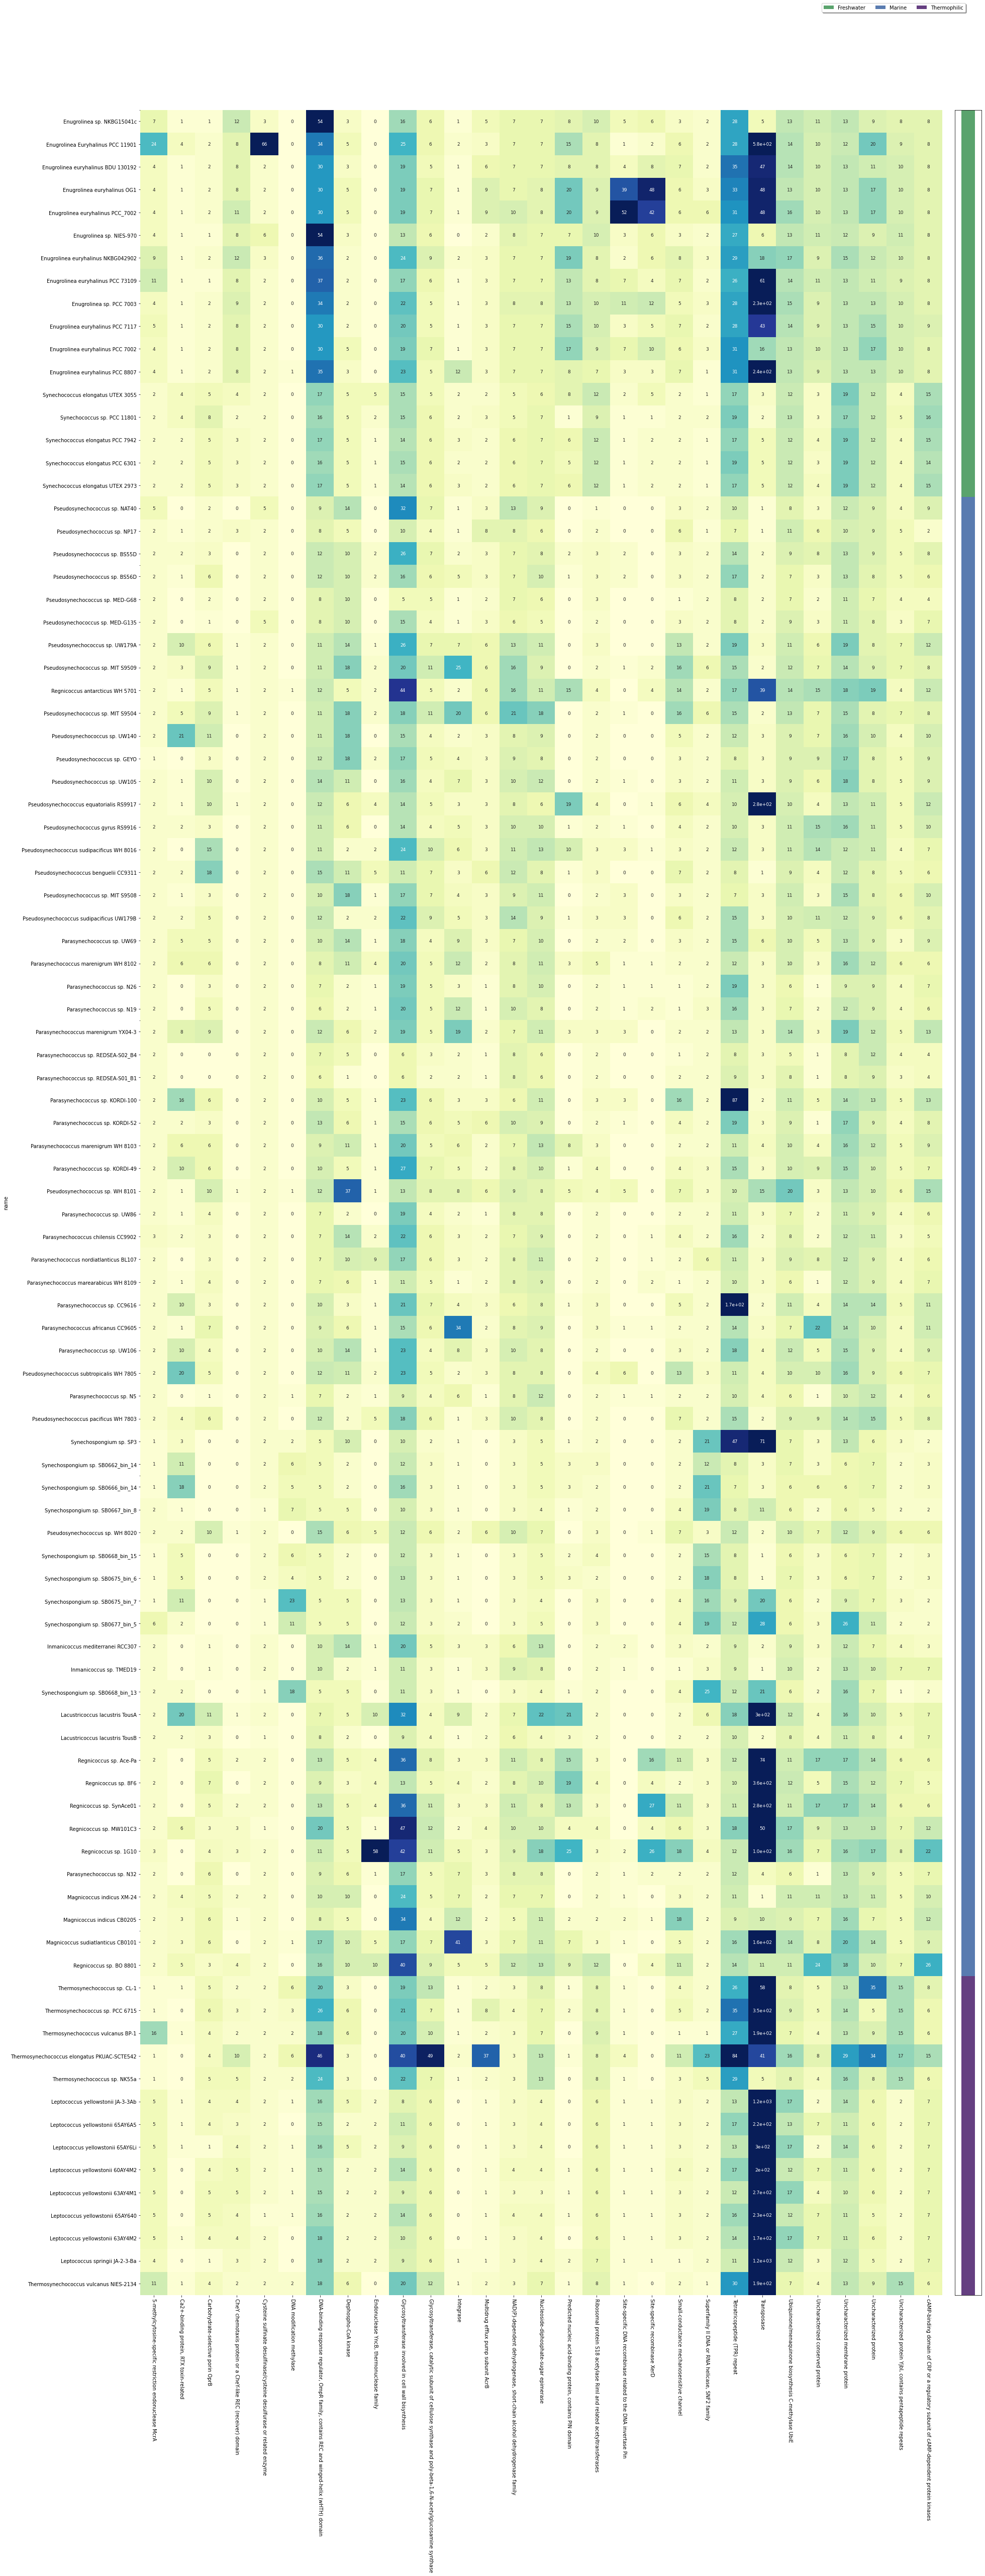

In [90]:
plotCOG(save="../data/plots/heatmap_by_genome_annot", annot=True, annot_kws={"size":9})

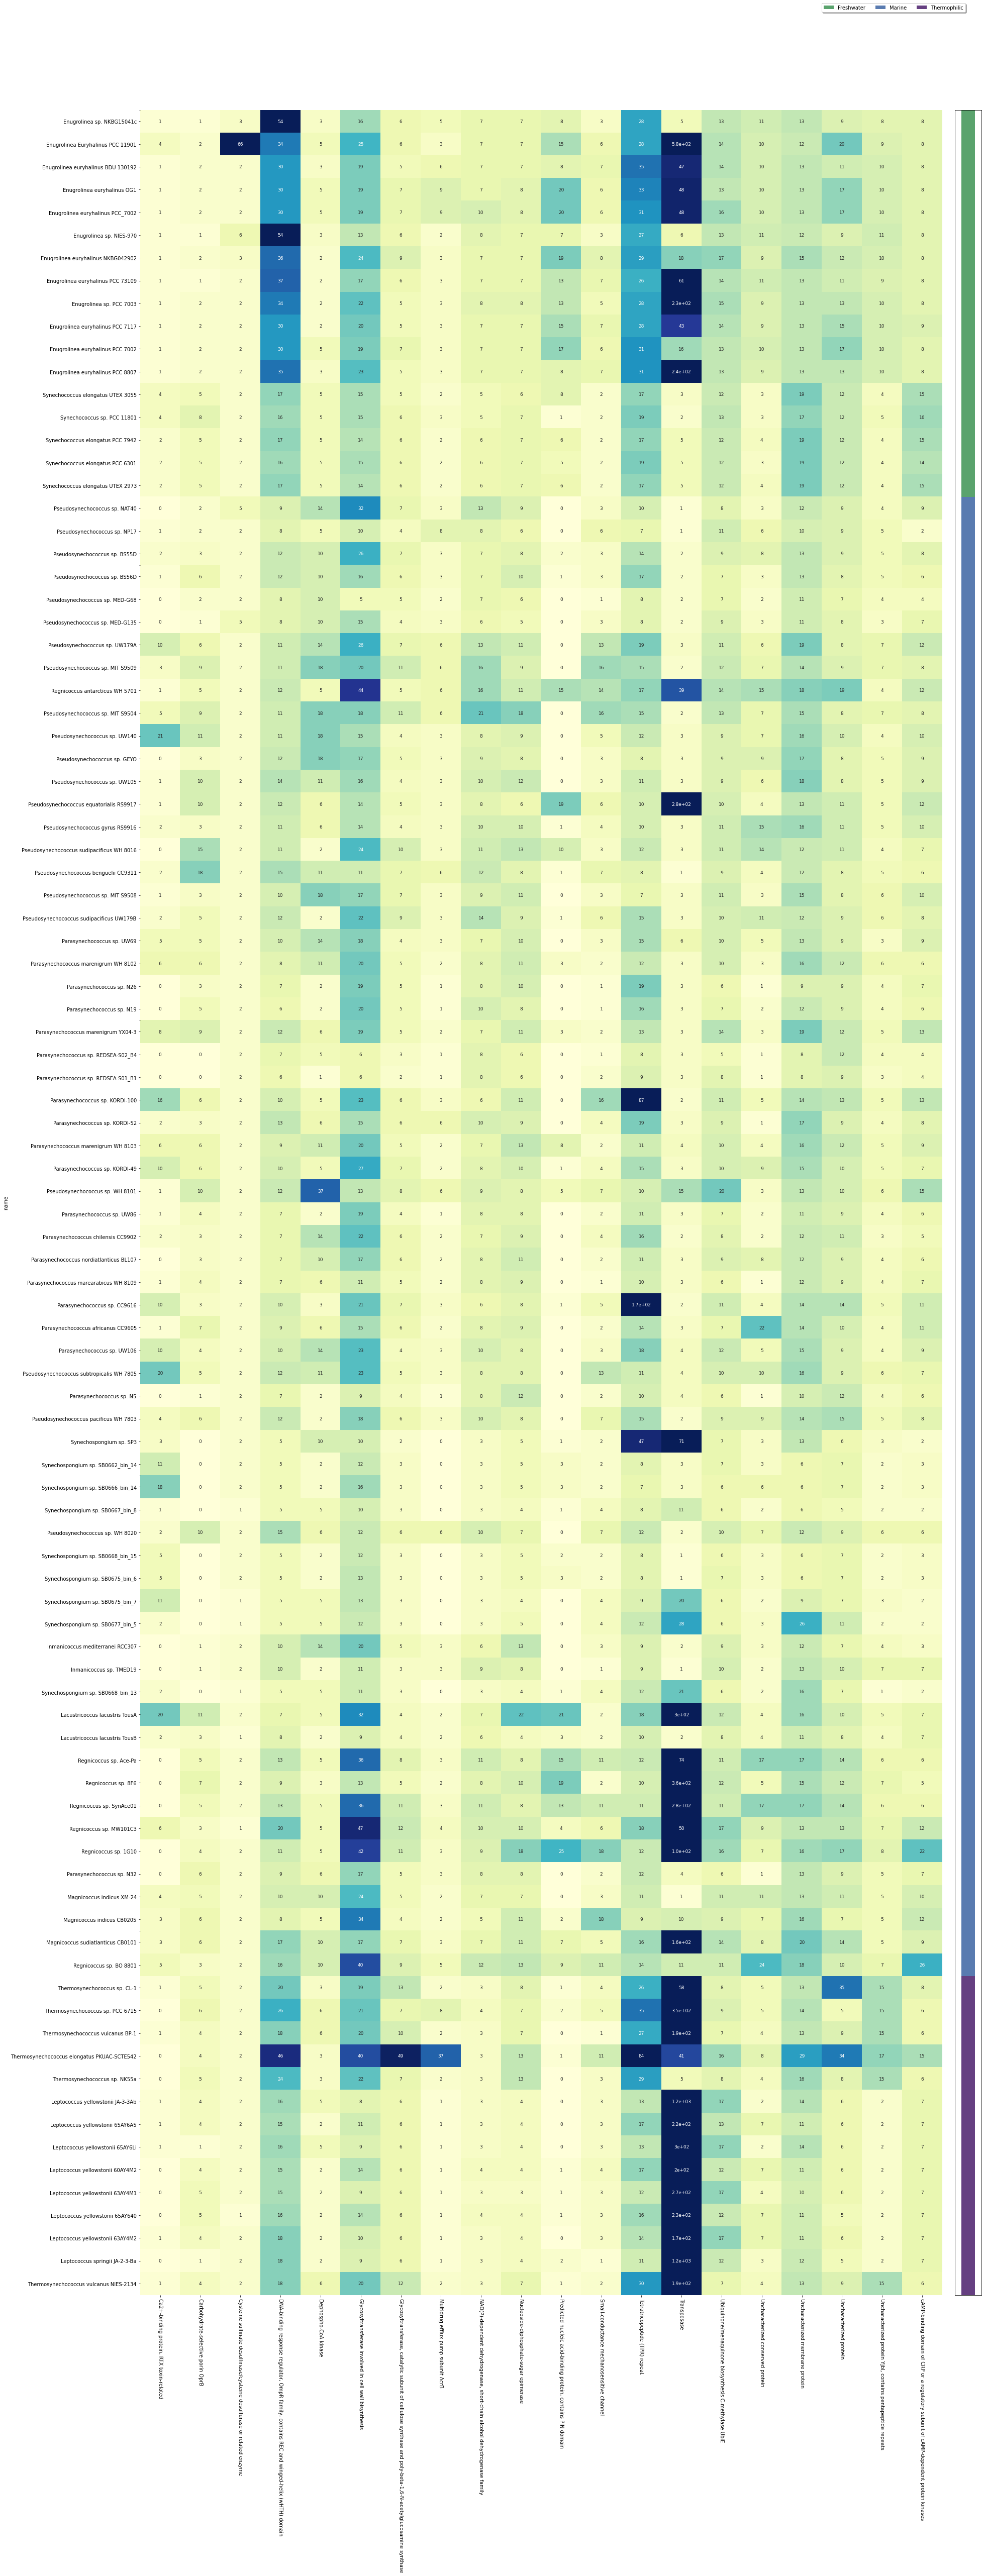

In [91]:
plotCOG(save="../data/plots/heatmap_by_genome_no_info_proc", mask=not_information_process, annot=True, annot_kws={"size":9})

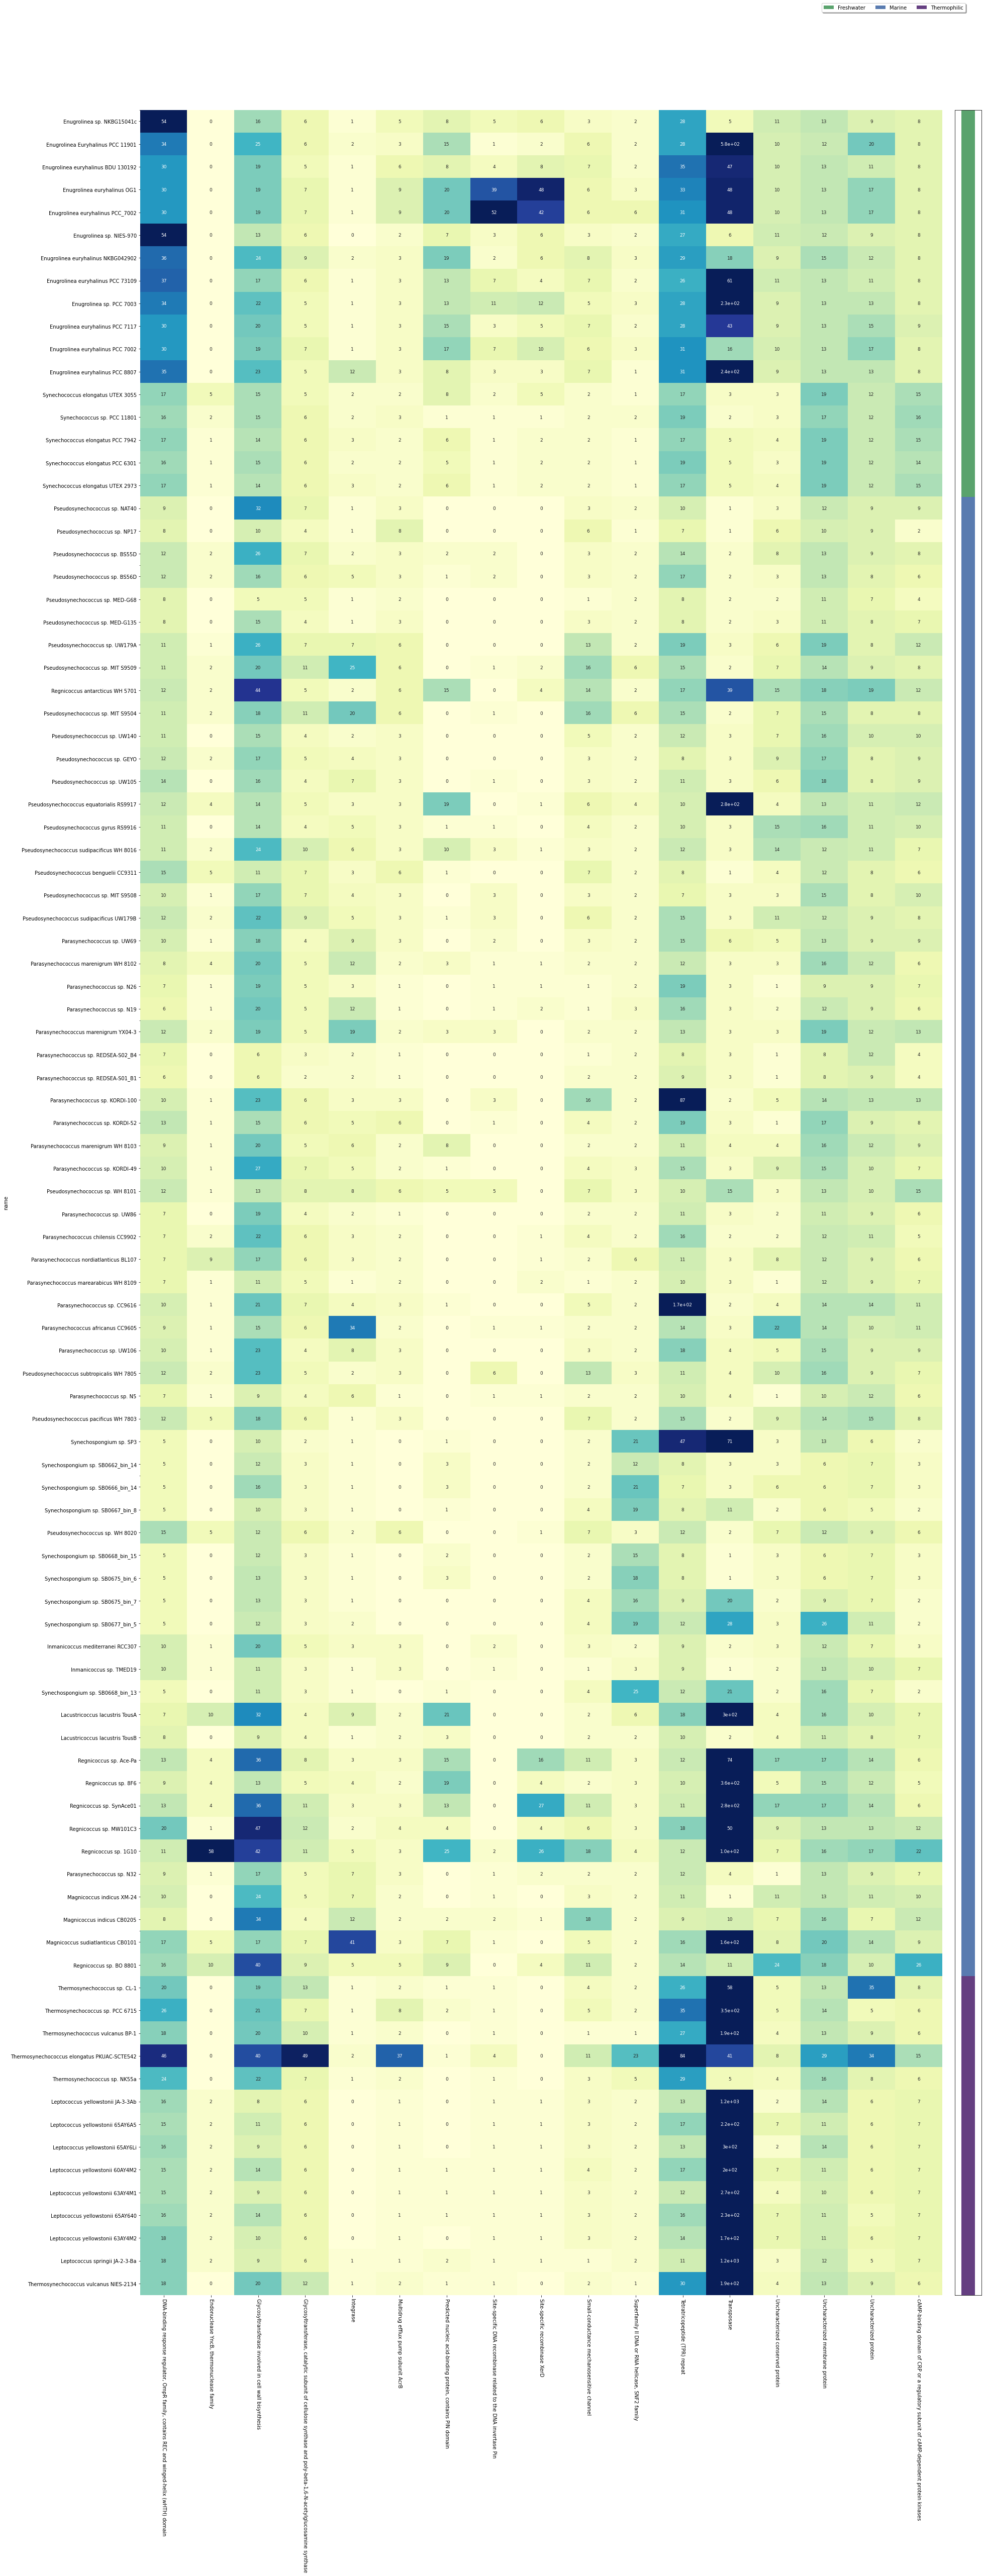

In [92]:
plotCOG(save="../data/plots/heatmap_by_genome_metabolism", mask=is_metabolism, annot=True, annot_kws={"size":9})

### Dataframe formatting

In [391]:
# Add COG names
columns = (cogt.letter_from_code(i)[0][1][1] for i in data.columns)
columns = (cogt.name_from_code(i) for i in data.columns)
data.columns = data.columns

# Collapse columns with same name
suffix = re.compile("\.[0-9]{1,2}$")
collapsed_columns = []
for s in data.columns:
    s_ = re.sub("\.[0-9]{1,2}$", "", s)
    if 'Transposase' in s:
        s_ = 'Transposase'
    collapsed_columns.append(s_)
    
data.columns = collapsed_columns
data_ = data.groupby(data.columns, axis=1).sum()
#data_ = data

In [392]:
color_dict = {
    "Freshwater":"#5AA36D",
    "Marine":"#597BB0",
    "Thermophilic":"#653F81"
}

In [393]:
# Collapse by genera
genera = set(i.split()[0] for i in data_.index)
data_['genus'] = ''
for ix, row in data_.iterrows():
    for g in genera:
        if g in ix:
            data_.loc[ix, 'genus'] = g
data_g = data_.groupby('genus').mean()

# Collapse by ecotypes
ecotypes = {
    'Enugrolinea': 'Freshwater',
    'Inmanicoccus': 'Marine',
    'Lacustricoccus': 'Marine',
    'Leptococcus':'Thermophilic',
    'Magnicoccus':'Marine',
    'Parasynechococcus':'Marine',
    'Pseudosynechococcus':'Marine',
    'Regnicoccus':'Marine',
    'Synechococcus':'Freshwater',
    'Synechospongium':'Marine',
    'Thermosynechococcus':'Thermophilic'}
data_['ecotype'] = data_['genus'].apply(lambda s: ecotypes[s])
data_e = data_.groupby('ecotype').mean()

# Sorting by ecotype
ecotype_df = pd.DataFrame([(k, v) for k,v in ecotypes.items()], columns=("genus", "ecotype"))
ecotype_df = ecotype_df.sort_values('ecotype')
ecotype_df.set_index("genus", inplace=True)

# Grouping by genus
data_ = data_g.loc[ecotype_df.index]

## could also group by ecotype
# data_ = data_e

In [394]:
data['genus'] = [i.split()[0] for i in data.index]
data['ecotype'] = data['genus'].apply(lambda s: ecotypes[s])
data = data.sort_values("ecotype")

In [402]:
data = data.groupby('genus').mean()

In [403]:
# Select features based on standard deviation
data_ = data.iloc[:, :-2]
var = data_.stack().std()
selector = VarianceThreshold(var)
selector.fit_transform(data_)
data_ = data_.iloc[:, selector.get_support(indices=True)]
data_ = data_.applymap(lambda n: round(n, 2))
data_.shape

(11, 34)

In [407]:
data_["Cell motility"]

genus
Enugrolinea             6.17
Inmanicoccus            4.00
Lacustricoccus          4.00
Leptococcus             6.00
Magnicoccus             5.33
Parasynechococcus       5.00
Pseudosynechococcus     6.45
Regnicoccus             8.71
Synechococcus           5.80
Synechospongium         2.89
Thermosynechococcus    16.33
Name: Cell motility, dtype: float64

### Plotting

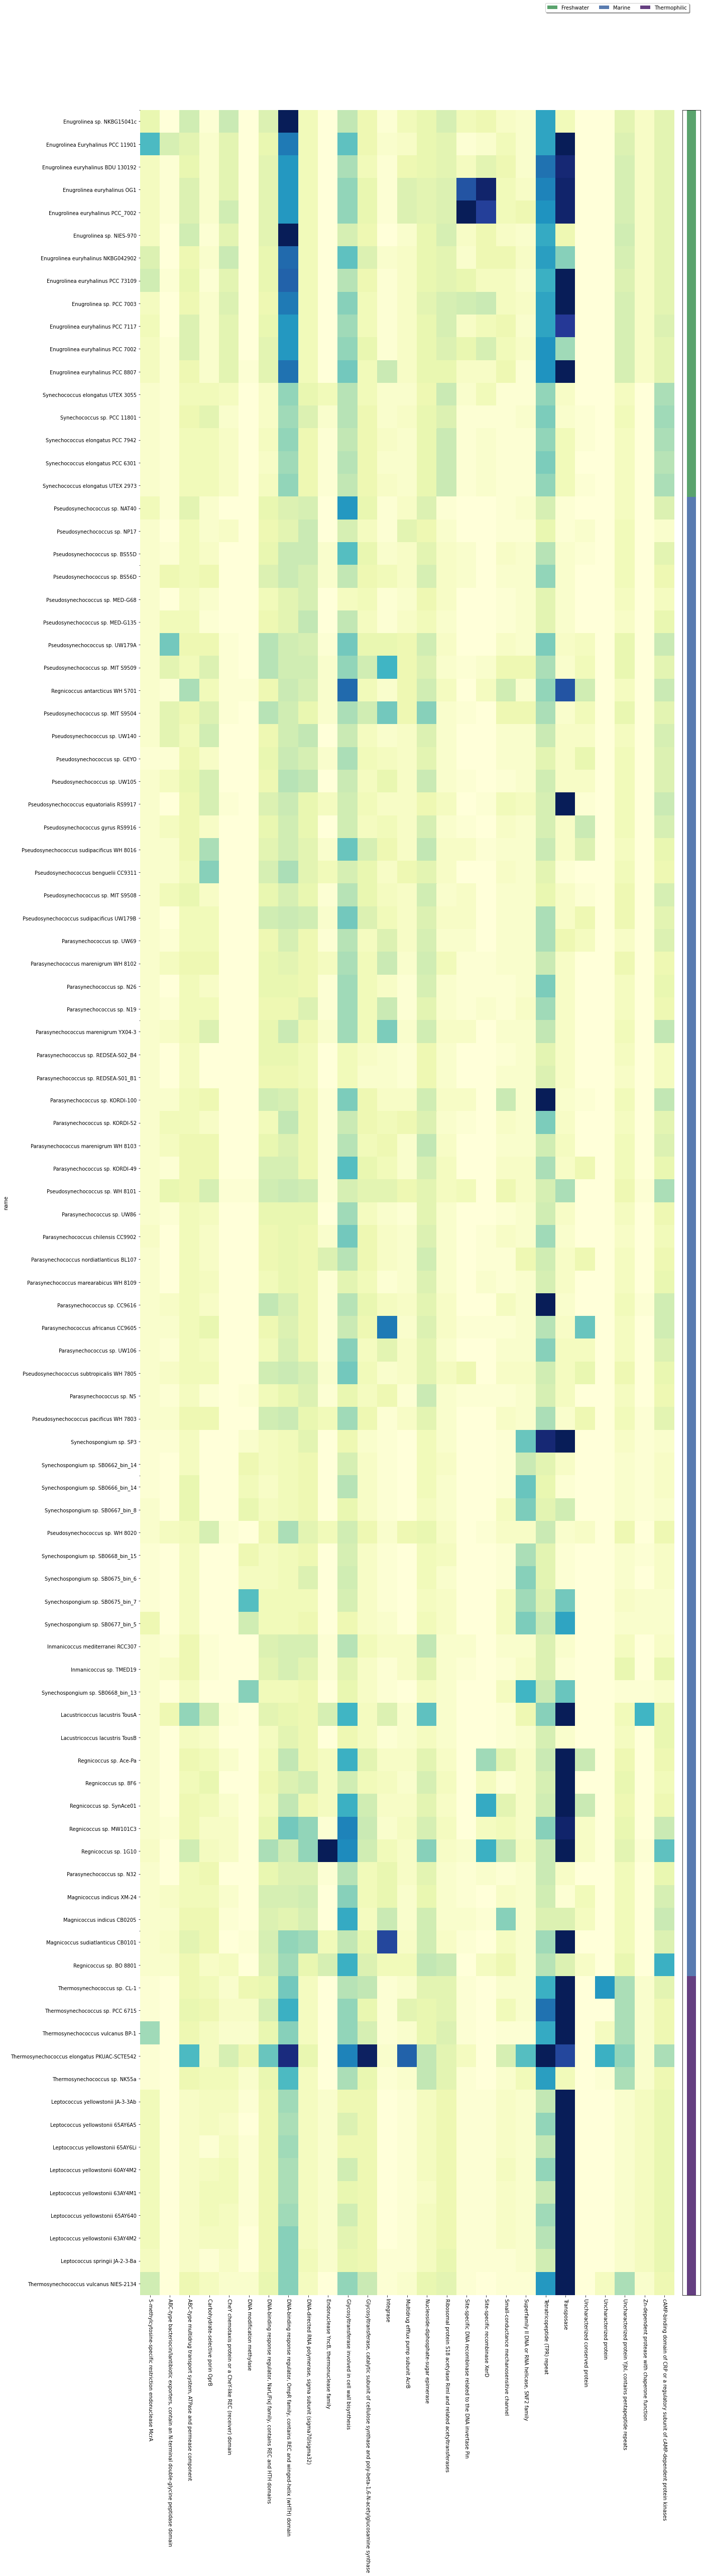

In [382]:
# Test for 190 columns
data_plot = data_
data_plot = data_plot.groupby(data_plot.columns, axis=1).sum()

gridkw = dict(width_ratios=[30, 1], wspace=0.03)
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20, 80), sharey=True)
sns.heatmap(data_plot, cmap="YlGnBu", cbar=False, vmax=50, ax=ax1)
ax1.tick_params(axis='x', rotation=-90)
ecotypes_ = pd.DataFrame(data['ecotype'].value_counts().loc['Freshwater Marine Thermophilic'.split()])
ecotypes_.T.plot.bar(stacked=True, color=("#5AA36D", "#597BB0", "#653F81"), ax=ax2)
ax2.set_xticks([])
ax2.tick_params(axis='both', which='both', length=0)
l = ax2.legend(loc='upper right', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
#plt.savefig("../data/plots/heatmap_metabolism_by_genome", dpi=300)

KeyError: 'ecotype'

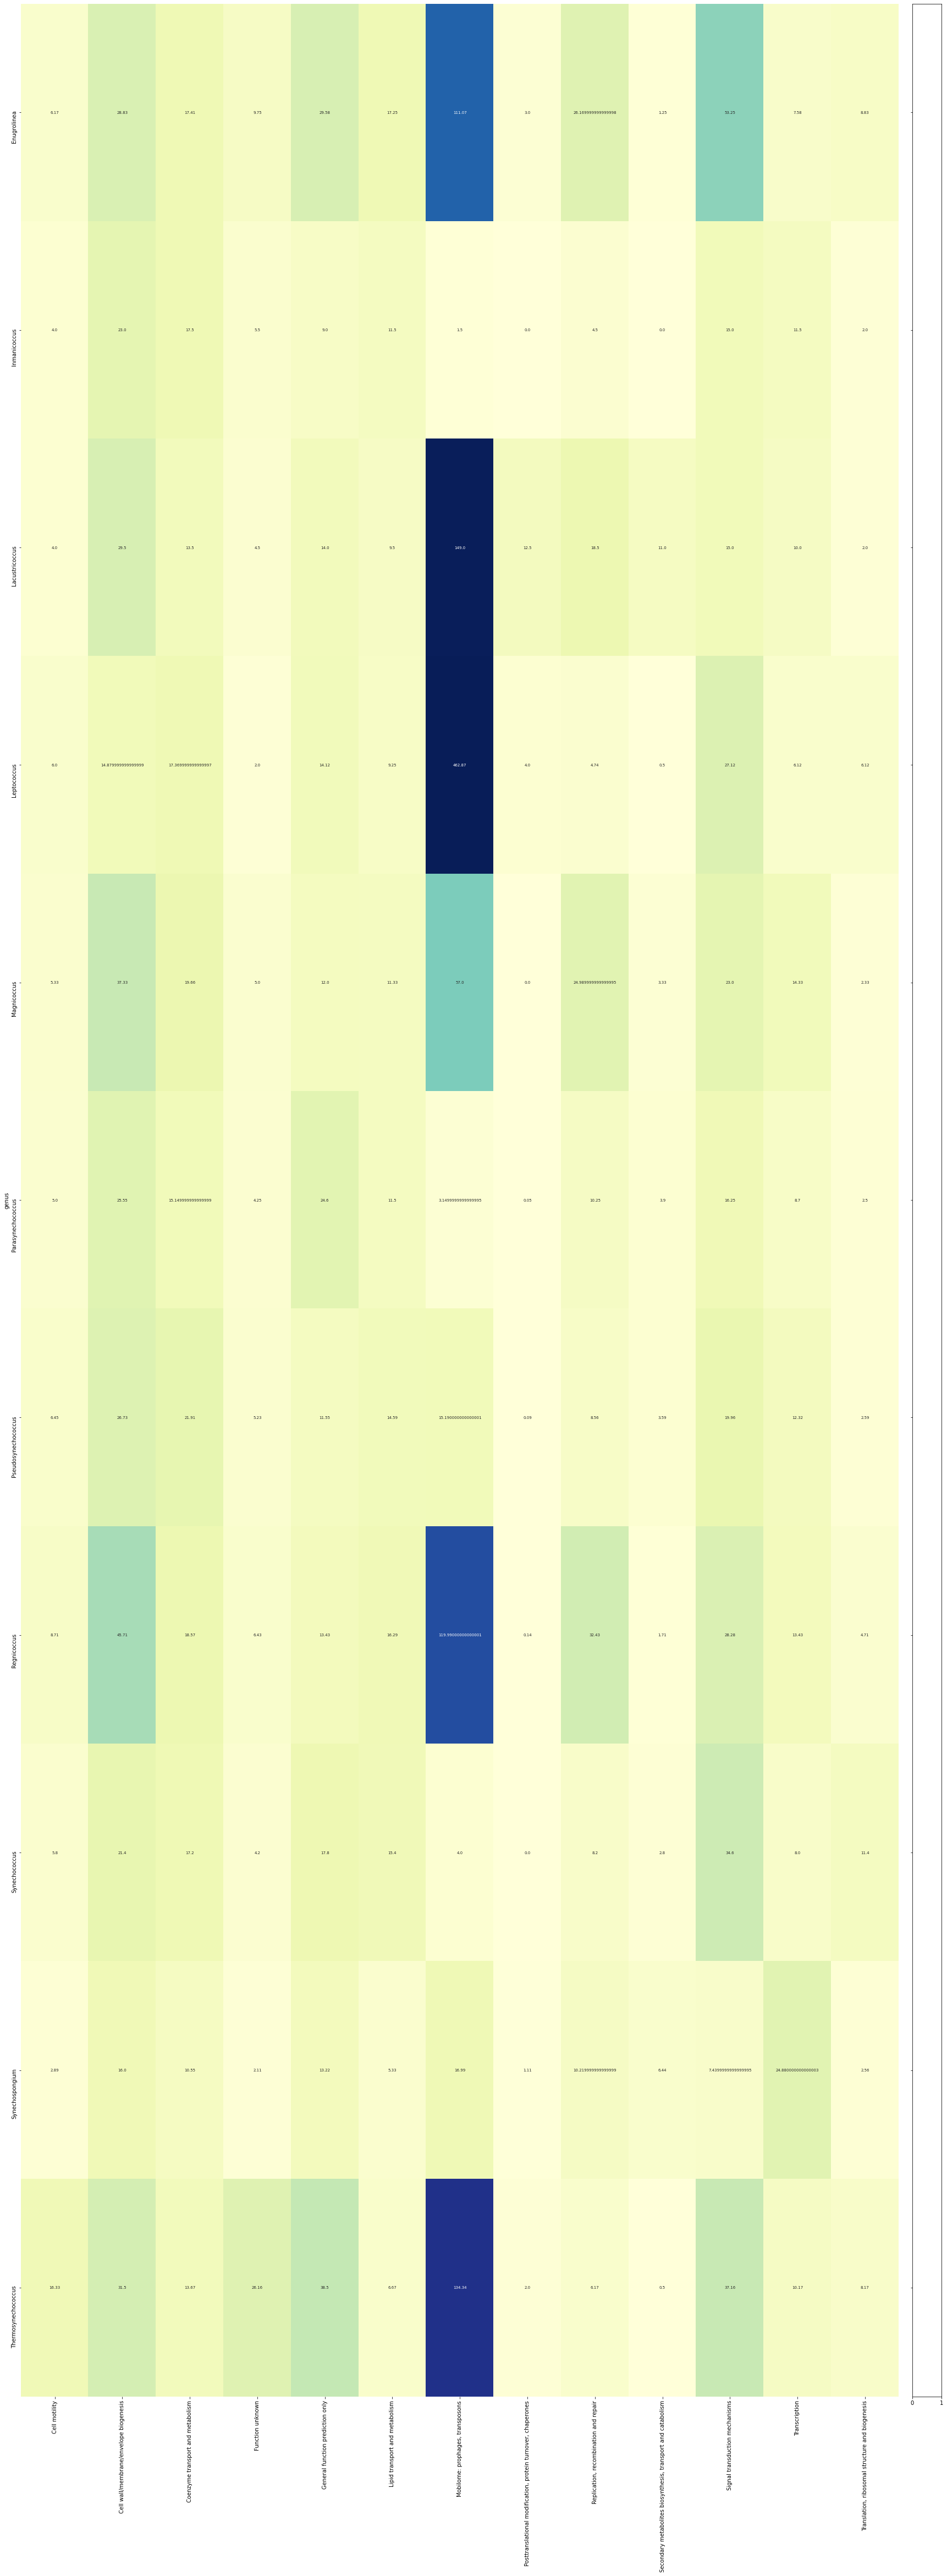

In [404]:
# Subset columns
#data_plot = data_[[i for i in data_.columns if "Uncharacterized" not in i and i != "Transposase"]]
data_plot = data_
data_plot = data_plot.groupby(data_plot.columns, axis=1).sum()

gridkw = dict(width_ratios=[30, 1], wspace=0.03)
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(30, 80), sharey=True)
sns.heatmap(data_plot, cmap="YlGnBu", annot=True, cbar=False, vmax=150, fmt="", ax=ax1, annot_kws={"size":7})
ecotypes_ = pd.DataFrame(data['ecotype'].value_counts().loc['Freshwater Marine Thermophilic'.split()])
ecotypes_.T.plot.bar(stacked=True, color=("#5AA36D", "#597BB0", "#653F81"), ax=ax2)
ax2.set_xticks([])
ax2.tick_params(axis='both', which='both', length=0)
l = ax2.legend(loc='upper right', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
#ax2.set_ticks([])

#plt.savefig("../data/plots/heatmap_COG_names_collapsed", dpi=300)
#plt.savefig("../data/plots/heatmap_metabolism_by_genome_annotated", dpi=300)

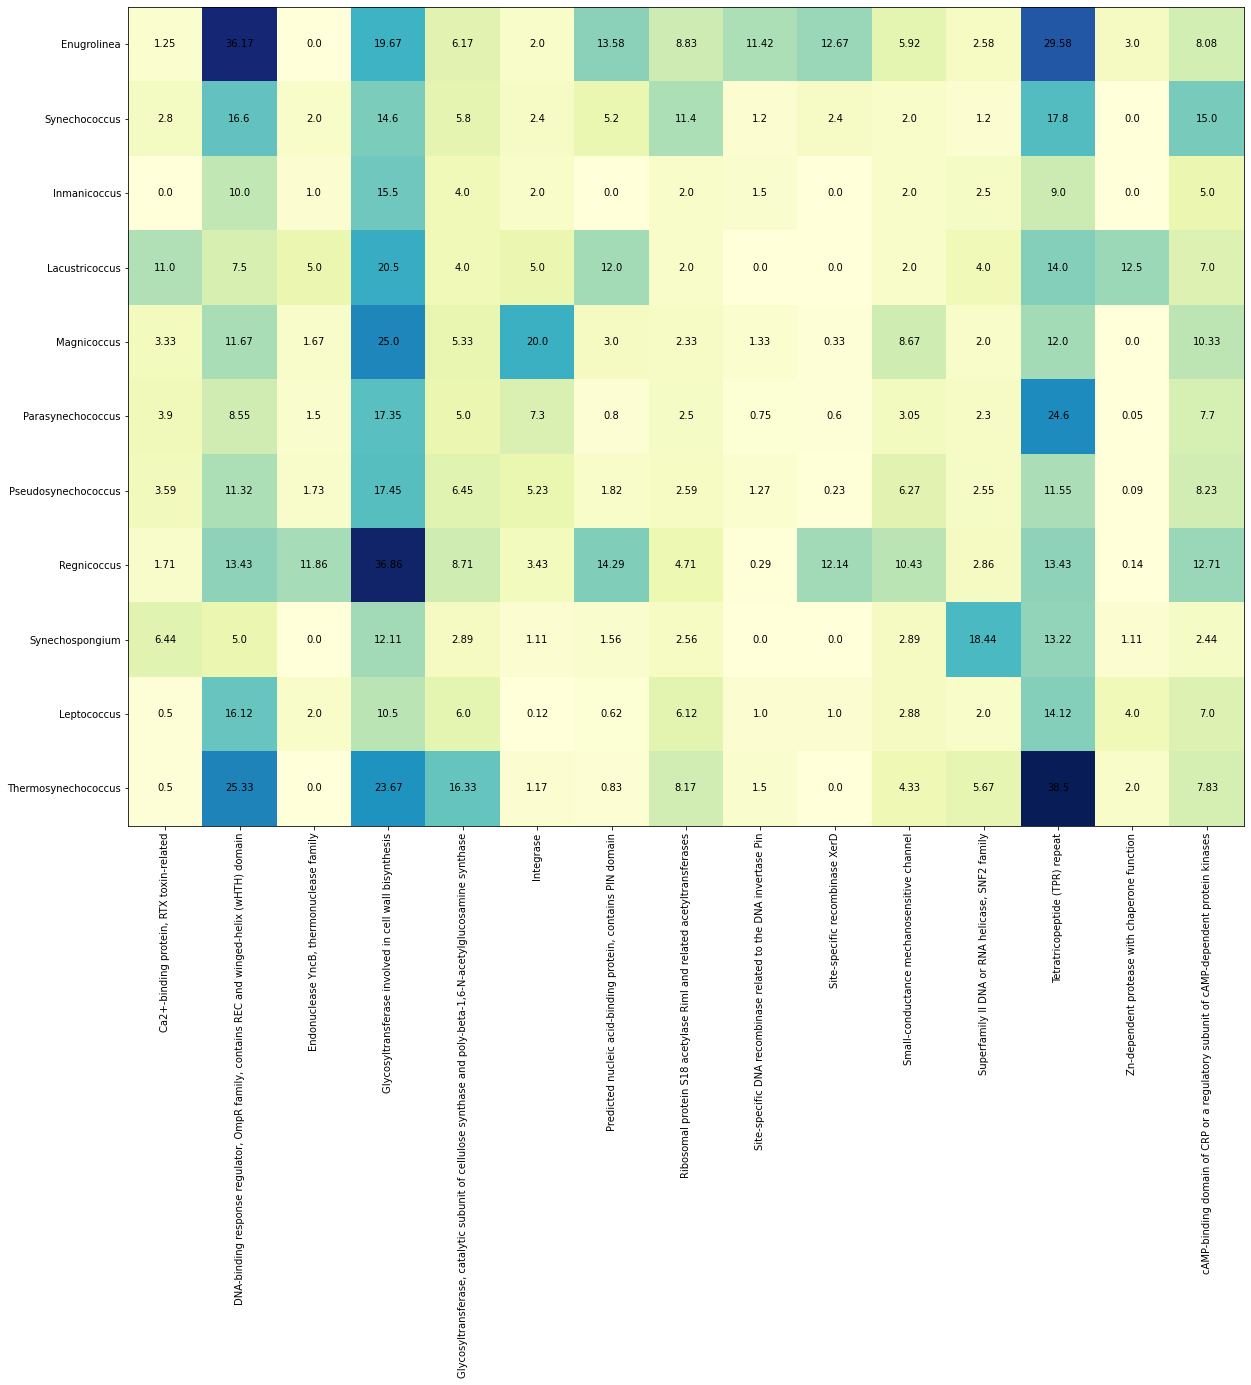

In [18]:
# Subset columns
data_plot = data_[[i for i in data_.columns if "Uncharacterized" not in i and i != "Transposase"]]
#data_plot = data_
values_ = np.array(data_plot.values, dtype=float)

fig, ax = plt.subplots(figsize=(20, 50))
mat = ax.imshow(values_, cmap='YlGnBu', interpolation='nearest')
plt.yticks(range(values_.shape[0]), data_plot.index)
plt.xticks([])
plt.xticks(range(values_.shape[1]), data_plot.columns)
plt.xticks(rotation=90)
ax.xaxis.set_label_position('top') 

# this places 0 or 1 centered in the individual squares
for x in range(values_.shape[0]):
    for y in range(values_.shape[1]):
        ax.annotate(str(values_[x, y]), xy=(y, x), 
                    horizontalalignment='center', verticalalignment='center')


# plt.savefig("../data/misc_data/presence_absence_heatmap.png", dpi=600)

### Check within genus variance vs whole dataframe variance

In [115]:
data_

,"Ca2+-binding protein, RTX toxin-related","DNA-binding response regulator, OmpR family, contains REC and winged-helix (wHTH) domain","Endonuclease YncB, thermonuclease family",Glycosyltransferase involved in cell wall bisynthesis,"Glycosyltransferase, catalytic subunit of cellulose synthase and poly-beta-1,6-N-acetylglucosamine synthase",Integrase,"Predicted nucleic acid-binding protein, contains PIN domain",Ribosomal protein S18 acetylase RimI and related acetyltransferases,Site-specific DNA recombinase related to the DNA invertase Pin,Site-specific recombinase XerD,Small-conductance mechanosensitive channel,"Superfamily II DNA or RNA helicase, SNF2 family",Tetratricopeptide (TPR) repeat,Transposase,Uncharacterized conserved protein,Uncharacterized protein,"Uncharacterized protein YjbI, contains pentapeptide repeats",Zn-dependent protease with chaperone function,cAMP-binding domain of CRP or a regulatory subunit of cAMP-dependent protein kinases
genus,,,,,,,,,,,,,,,,,,,
Enugrolinea,1.25,36.17,0.00,19.67,6.17,2.00,13.58,8.83,11.42,12.67,5.92,2.58,29.58,111.58,9.92,13.67,9.75,3.00,8.08
Synechococcus,2.80,16.60,2.00,14.60,5.80,2.40,5.20,11.40,1.20,2.40,2.00,1.20,17.80,4.00,3.40,12.00,4.20,0.00,15.00
Inmanicoccus,0.00,10.00,1.00,15.50,4.00,2.00,0.00,2.00,1.50,0.00,2.00,2.50,9.00,1.50,2.50,8.50,5.50,0.00,5.00
Lacustricoccus,11.00,7.50,5.00,20.50,4.00,5.00,12.00,2.00,0.00,0.00,2.00,4.00,14.00,150.00,4.00,9.00,4.50,12.50,7.00
Magnicoccus,3.33,11.67,1.67,25.00,5.33,20.00,3.00,2.33,1.33,0.33,8.67,2.00,12.00,57.67,8.67,10.67,5.00,0.00,10.33
Parasynechococcus,3.90,8.55,1.50,17.35,5.00,7.30,0.80,2.50,0.75,0.60,3.05,2.30,24.60,3.20,4.05,10.40,4.25,0.05,7.70
Pseudosynechococcus,3.59,11.32,1.73,17.45,6.45,5.23,1.82,2.59,1.27,0.23,6.27,2.55,11.55,15.45,6.68,9.18,5.23,0.09,8.23
Regnicoccus,1.71,13.43,11.86,36.86,8.71,3.43,14.29,4.71,0.29,12.14,10.43,2.86,13.43,130.29,13.43,14.14,6.43,0.14,12.71
Synechospongium,6.44,5.00,0.00,12.11,2.89,1.11,1.56,2.56,0.00,0.00,2.89,18.44,13.22,17.67,3.00,7.11,2.11,1.11,2.44


In [102]:
# data_ = data.groupby(data.columns, axis=1).sum()
# data_['genus'] = ''
# for ix, row in data_.iterrows():
#     for g in genera:
#         if g in ix:
#             data_.loc[ix, 'genus'] = g
            
# group = data_.groupby('genus').describe()

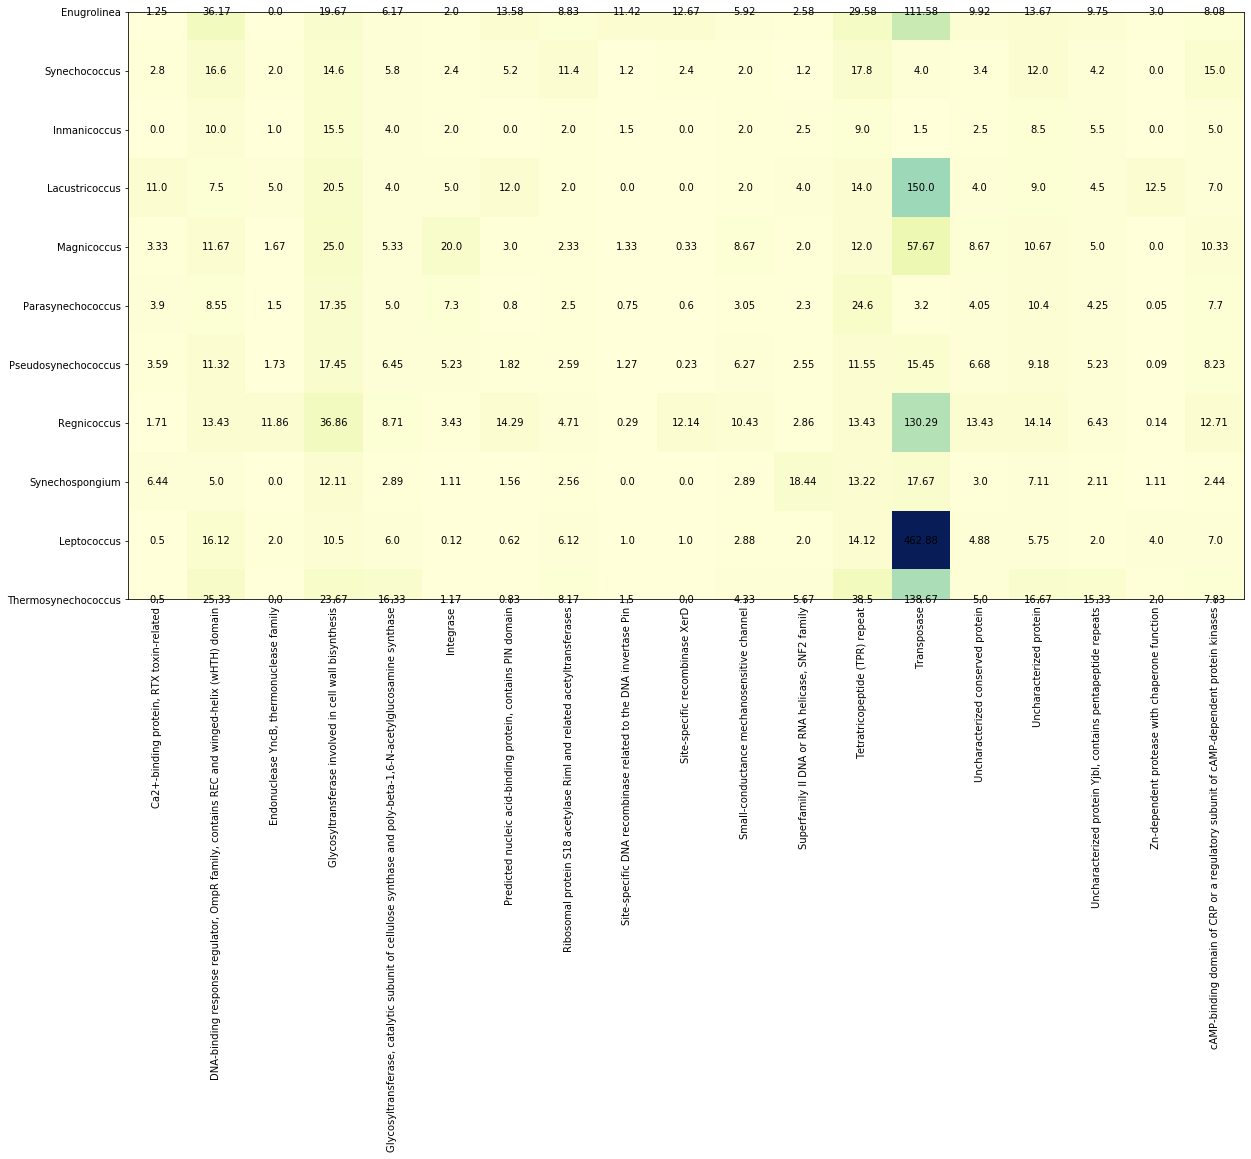

In [77]:
' '.join([i[1][0] for i in cogt.letter_from_code('COG0237')]), ', '.join([i[1][0] for i in cogt.letter_from_code('COG0745')])

['Glutamate-1-semialdehyde aminotransferase',
 'Xaa-Pro aminopeptidase',
 'Arginase family enzyme',
 'Alanyl-tRNA synthetase',
 'Adenylosuccinate lyase',
 'Diaminopimelate decarboxylase',
 'Pyruvate/2-oxoglutarate/acetoin dehydrogenase complex, dehydrogenase (E1) component',
 'Formate-dependent phosphoribosylglycinamide formyltransferase (GAR transformylase)',
 'Glutamine phosphoribosylpyrophosphate amidotransferase',
 'Pentose-5-phosphate-3-epimerase',
 'H+/Cl- antiporter ClcA',
 'Isoleucyl-tRNA synthetase',
 'Histidinol-phosphate/aromatic aminotransferase or cobyric acid decarboxylase',
 'Imidazole glycerol phosphate synthase subunit HisF',
 '3,4-dihydroxy-2-butanone 4-phosphate synthase',
 'Acetyltransferase (isoleucine patch superfamily)',
 'Phosphoglycerate dehydrogenase or related dehydrogenase',
 'Delta-aminolevulinic acid dehydratase, porphobilinogen synthase',
 'Branched-chain amino acid aminotransferase/4-amino-4-deoxychorismate lyase',
 'Imidazoleglycerol phosphate synthase 

In [3]:
for k in range(2, 12):
    km = KMeans(n_clusters=k)
    km.fit(mat)
    labels = km.labels_
    results = pd.DataFrame([data.index, labels]).T
    results.columns=("Genome", "K-group")
    results.sort_values(["K-group", "Genome"], inplace=True)
    # results.to_csv(f"../data/tables/kmeans/{k}-means-allCOGs.csv", index=False)

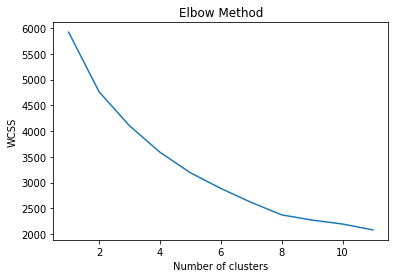

In [4]:
wcss = []
for i in range(1, 12):  # 11 is the number of genera
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(mat)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [5]:
plot_file = "../data/tables/cog/CyCOG_binary_95_completeness.csv"
plot_table = pd.read_csv(plot_file, index_col="name")

In [6]:
# COG-translator is a package to quickly translate COG codes
# Easily install it with $ pip install COG-translator
from COG import COGTranslator
cogt = COGTranslator()
names = dict()
for k, v in cogt.codes.items():
    names[v["name"]] = k
plot_table.rename(columns=names, inplace=True)

Loaded 4631 COG names into memory.


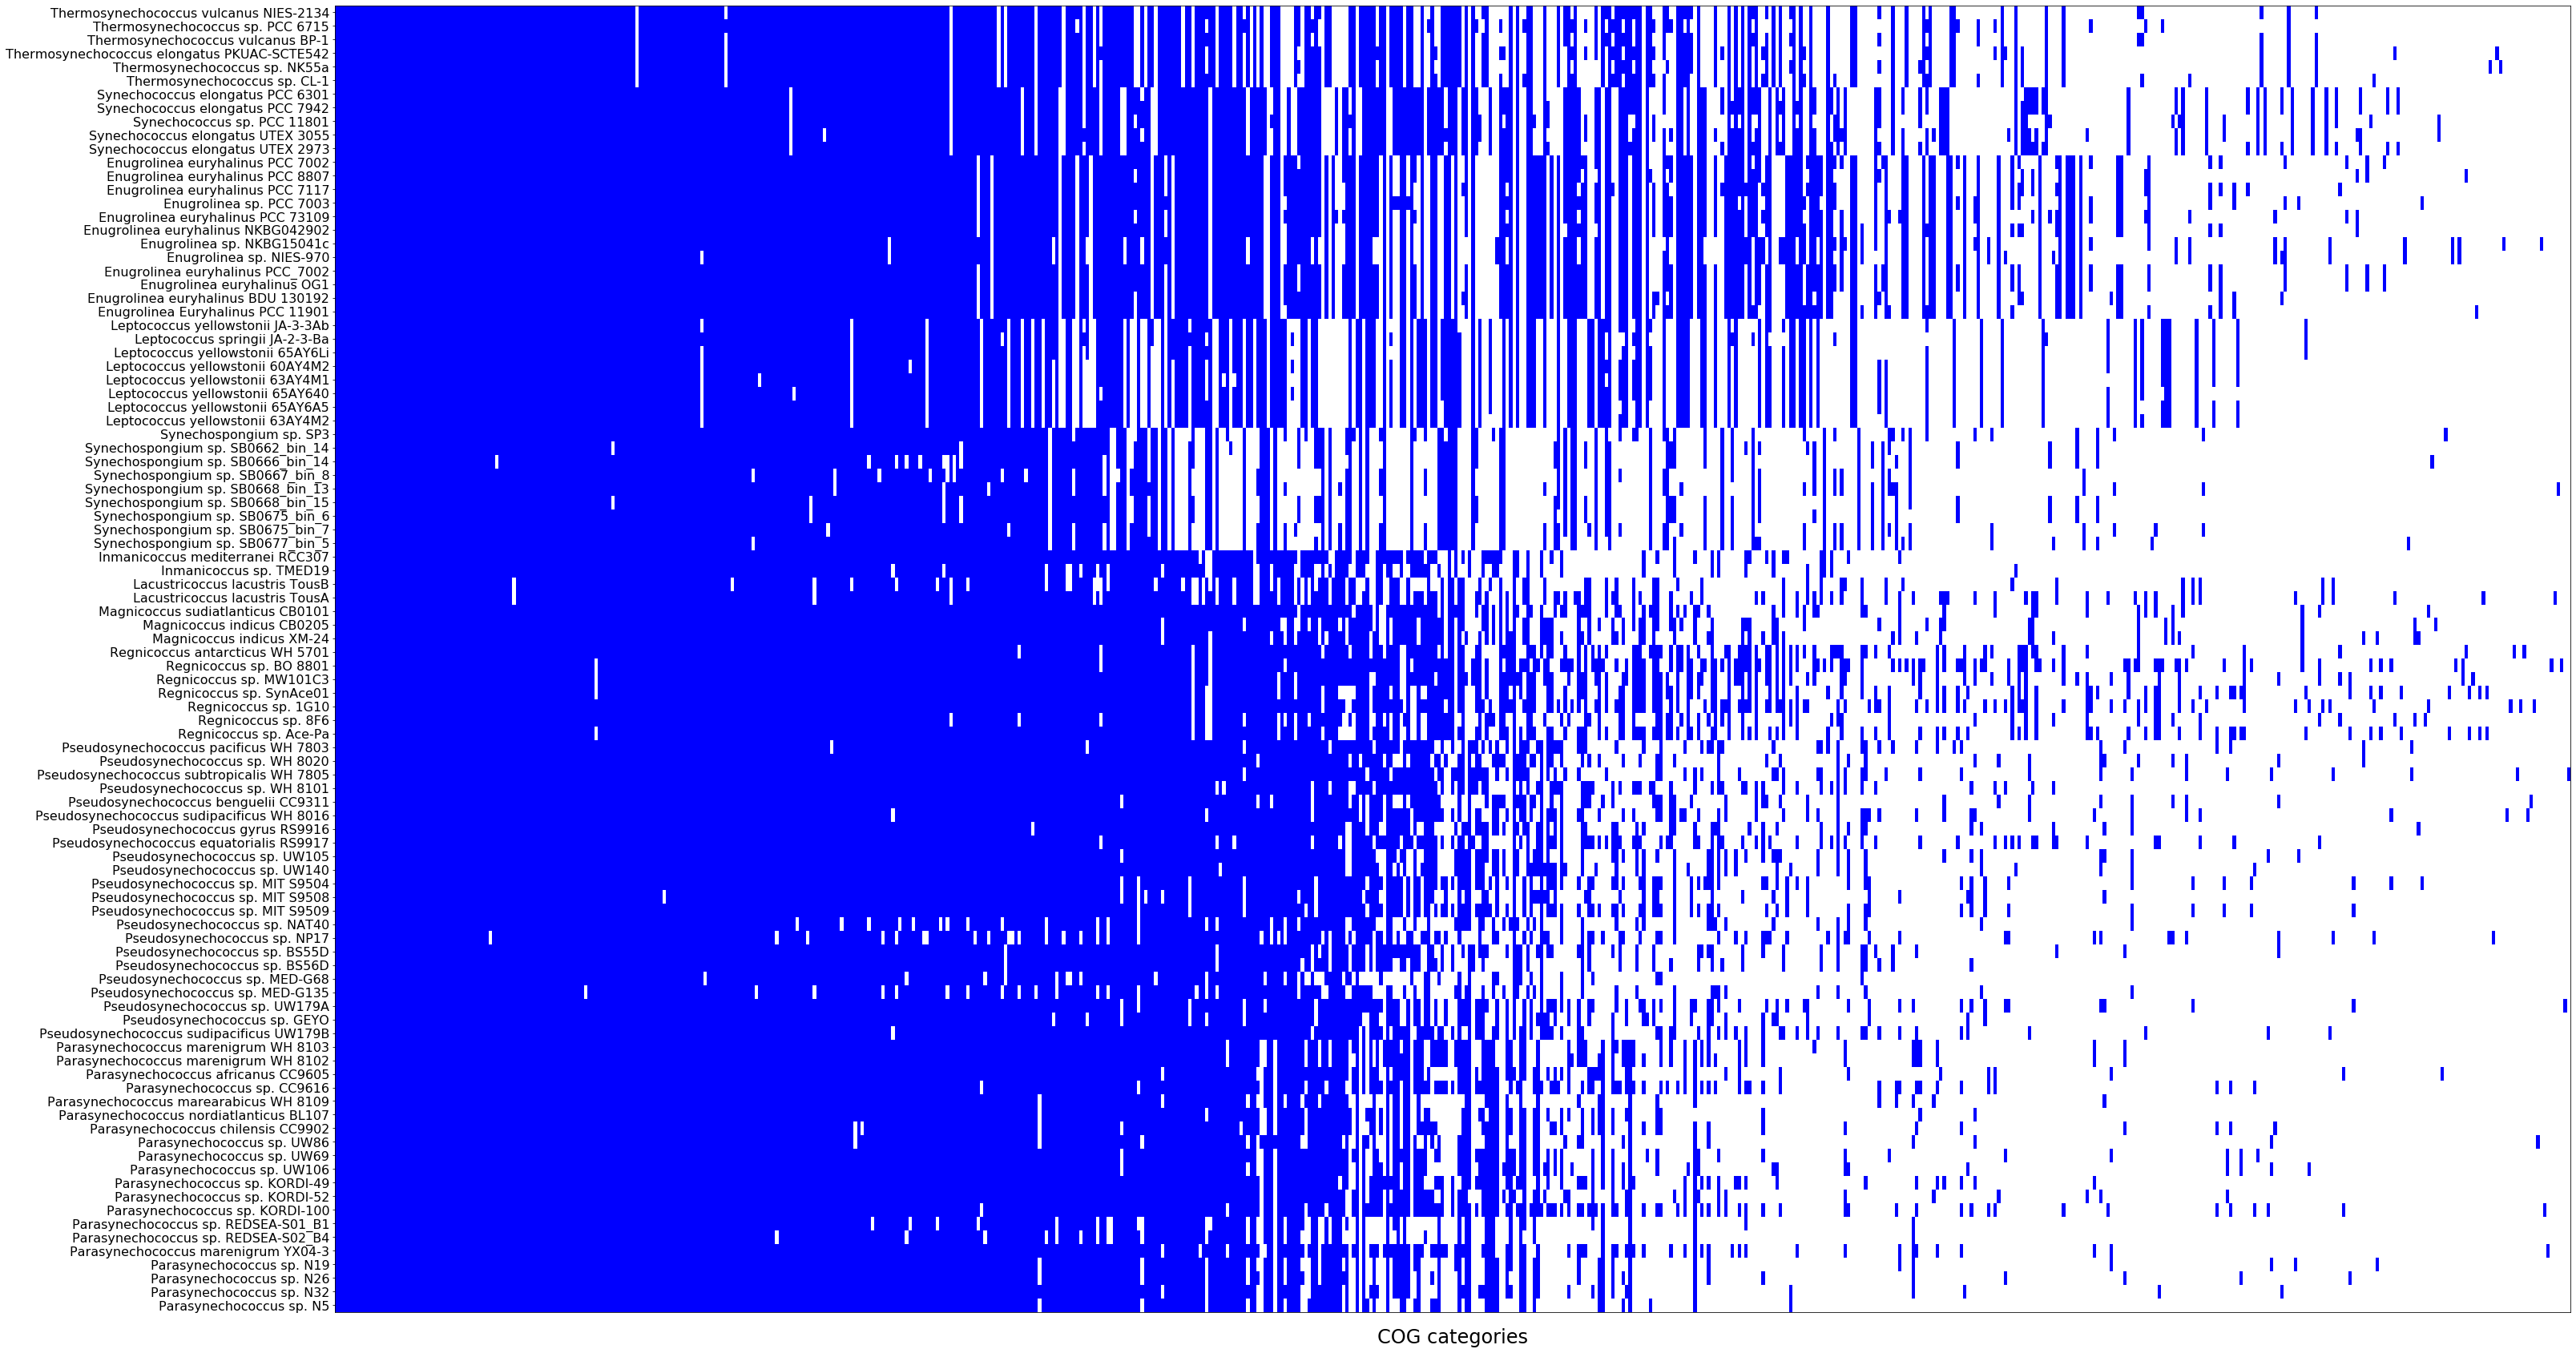

In [7]:
fig, ax = plt.subplots(figsize=(50, 30))

cmap = mpl.colors.ListedColormap(['w', 'b'])
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.tick_params(
    axis='x',        
    which='both',    
    bottom=False,    
    top=False,       
    labelbottom=False
)

ax.set_xlabel('COG categories', fontsize=24, labelpad=20)
yticks = plt.yticks(range(plot_table.shape[0]), plot_table.index, fontsize=16)
image = ax.imshow(plot_table, interpolation='none', cmap=cmap, norm=norm, aspect="auto")

# Uncomment this if you wish COG names in the xticks
# xticks = plt.xticks(range(plot_table.shape[1]), plot_table.columns, rotation=90)
# xticks = ax.tick_params(axis='both', which='minor', labelsize=8)

# Uncomment to save
plt.savefig("../data/plots/CyCOG_presence_absence.png", dpi=300, bbox_inches='tight')

In [8]:
# Reading data into a single df
tables = dict()
for k in (2, 3, 4):
    tables[k] = pd.read_csv(f"../data/tables/kmeans/{k}-means-CyCOGs.csv")
COG_df = tables[2].merge(
    tables[3], on="Genome").merge(
    tables[4], on="Genome")
COG_df.columns=("Genome", "2-means", "3-means", "4-means")

# Translating cluster number into ecological groups
trans = {
    "2-means": {
        0: "Seawater",
        1: "Freshwater/Thermal"
    },
    "3-means": {
        0: "Seawater",
        1: "Symbiont",
        2: "Freshwater/Thermal"
    },
    "4-means": {
        0: "Thermal",
        1: "Seawater",
        2: "Symbiont",
        3: "Freshwater"
    },
}

for k in (2, 3, 4):
    COG_df[f"{k}-means"] = COG_df[f"{k}-means"].apply(lambda n: trans[f"{k}-means"][n])
    
COG_df["Genus"] = COG_df["Genome"].apply(lambda s: s.split()[0])

In [9]:
table2 = COG_df.drop_duplicates(subset=("Genus"))[[
    "Genus", "2-means", "3-means", "4-means"]].copy()


table2.reset_index(inplace=True)
reindex = list(table2["index"])
reindex = reindex[:7] + [65, 85, 90, 77]
table2 = table2.set_index("index").reindex(reindex[::-1])
table2.set_index("Genus", inplace=True)
table2.to_csv("../data/tables/Table_2.csv")